In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
!ls

LICENSE    env.yml	 examples  notebooks
README.md  env_norl.yml  mypy.ini  sustaingym


In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv



from sustaingym.envs.battery.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv

In [5]:
def training_results(folder):
    results = []
    fname = f'examples/{folder}/evaluations.npz'
    x = np.load(fname, allow_pickle=True)
    results.append(x['results'])

    timesteps = x['timesteps']
    results = np.hstack(results)
    y = results.mean(axis=1)
    error = results.std(axis=1)
    return timesteps, y, error

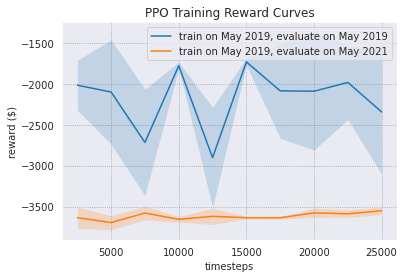

<Figure size 432x288 with 0 Axes>

In [10]:
timesteps, y_in_dist, error_in_dist = training_results('logs_PPO/in_dist')
plt.plot(timesteps, y_in_dist, label='train on May 2019, evaluate on May 2019')
plt.fill_between(timesteps, y_in_dist-error_in_dist, y_in_dist+error_in_dist, alpha=0.2)

timesteps, y_out_dist, error_out_dist = training_results('logs_PPO/out_dist')
plt.plot(timesteps, y_out_dist, label='train on May 2019, evaluate on May 2021')
plt.fill_between(timesteps, y_out_dist-error_out_dist, y_out_dist+error_out_dist, alpha=0.2)

plt.title('PPO Training Reward Curves')

plt.ylabel('reward ($)')
plt.xlabel('timesteps')
plt.legend()
plt.show()

plt.savefig('examples/logs_PPO/ppo_reward_curves.png', dpi=300)

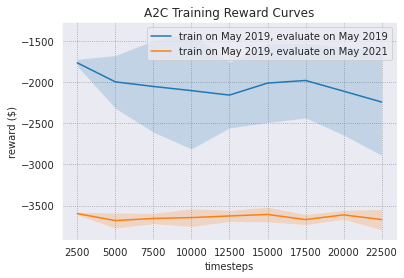

<Figure size 432x288 with 0 Axes>

In [11]:
timesteps, y_in_dist, error_in_dist = training_results('logs_A2C/in_dist')
plt.plot(timesteps, y_in_dist, label='train on May 2019, evaluate on May 2019')
plt.fill_between(timesteps, y_in_dist-error_in_dist, y_in_dist+error_in_dist, alpha=0.2)

timesteps, y_out_dist, error_out_dist = training_results('logs_A2C/out_dist')
plt.plot(timesteps, y_out_dist, label='train on May 2019, evaluate on May 2021')
plt.fill_between(timesteps, y_out_dist-error_out_dist, y_out_dist+error_out_dist, alpha=0.2)

plt.title('A2C Training Reward Curves')

plt.ylabel('reward ($)')
plt.xlabel('timesteps')
plt.legend()
plt.show()

plt.savefig('examples/logs_A2C/a2c_reward_curves.png', dpi=300)

In [12]:
def run_model_for_evaluation(model, episodes, env):
    """
    Run a model for a number of episodes and return the mean and std of the reward.
    :param model: (BaseRLModel object) the model to evaluate
    :param episodes: (int) number of episodes to evaluate for
    :param env: (Gym Environment) the environment to evaluate the model on
    :return: (np.ndarray) rewards for episodes
    """
    episode_rewards = []
    for i in range(episodes):
        obs = env.reset(seed = i*10)
        done = False
        rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            rewards[env.count] = reward
        episode_rewards.append(np.sum(rewards))
    return episode_rewards

In [13]:
def get_offline_optimal(episodes, env):
    """
    Get the offline optimal reward for a number of episodes.
    :param episodes: (int) number of episodes to evaluate for
    :param env: (Gym Environment) the environment to evaluate the model on
    :return: (np.ndarray) rewards for episodes
    """
    episode_rewards = []
    for i in range(episodes):
        obs = env.reset(seed = i*10)
        episode_rewards.append(env._calculate_realistic_off_optimal_total_episode_reward())
    return episode_rewards

In [14]:
def get_random_action_rewards(episodes, env):
    episode_rewards = []
    for i in range(episodes):
        obs = env.reset(seed = i*10)
        done = False
        rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
        while not done:
            action = env.action_space.sample()
            obs, reward, done, _ = env.step(action)
            rewards[env.count] = reward
        episode_rewards.append(np.sum(rewards))
    return episode_rewards

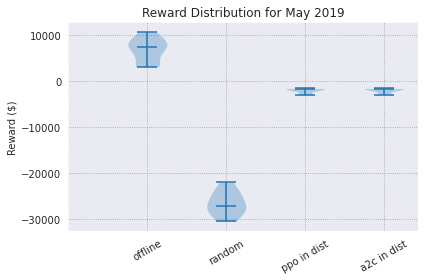

In [15]:
fig, ax = plt.subplots()

env_2019 = BatteryStorageInGridEnv(month='2019-05', seed=195)
env_2021 = BatteryStorageInGridEnv(month='2021-05', seed=215)

ppo_in_dist = PPO.load('examples/model_2019_5.zip')
a2c_in_dist = A2C.load('examples/model_A2C_2019_5.zip')

offline_rewards = get_offline_optimal(10, env_2019)
ppo_in_dist_rewards = run_model_for_evaluation(ppo_in_dist, 10, env_2019)
a2c_in_dist_rewards = run_model_for_evaluation(a2c_in_dist, 10, env_2019)
random_rewards = get_random_action_rewards(10, env_2019)

data = [offline_rewards, random_rewards, ppo_in_dist_rewards, a2c_in_dist_rewards]
labels = ['', 'offline', 'random', 'ppo in dist', 'a2c in dist']

ax.violinplot(data, showmedians=True)

ax.set_ylabel('Reward ($)')
ax.set_title('Reward Distribution for May 2019')
x = np.arange(len(labels))  # the label locations
ax.set_xticks(x, labels)
plt.xticks(rotation=30)

fig.tight_layout()

plt.savefig('algo_comp_2019.png', dpi=300)
plt.show()


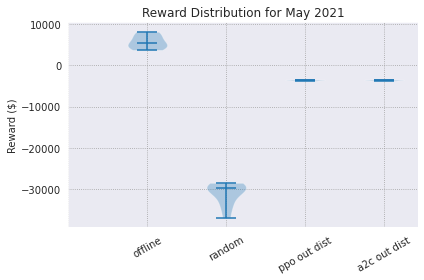

In [16]:
fig, ax = plt.subplots()

env_2021 = BatteryStorageInGridEnv(month='2021-05', seed=215)

ppo_in_dist = PPO.load('examples/model_2019_5.zip')
a2c_in_dist = A2C.load('examples/model_A2C_2019_5.zip')

offline_rewards = get_offline_optimal(10, env_2021)
ppo_out_dist_rewards = run_model_for_evaluation(ppo_in_dist, 10, env_2021)
a2c_out_dist_rewards = run_model_for_evaluation(a2c_in_dist, 10, env_2021)
random_rewards = get_random_action_rewards(10, env_2021)

data = [offline_rewards, random_rewards, ppo_out_dist_rewards, a2c_out_dist_rewards]
labels = ['', 'offline', 'random', 'ppo out dist', 'a2c out dist']

ax.violinplot(data, showmedians=True)

ax.set_ylabel('Reward ($)')
ax.set_title('Reward Distribution for May 2021')
x = np.arange(len(labels))  # the label locations
ax.set_xticks(x, labels)
plt.xticks(rotation=30)

fig.tight_layout()

plt.savefig('algo_comp_2021.png', dpi=300)
plt.show()